# Epidemic Model for Digital Herd Immunity

## Introduction

In this notebook we will numerically explore a model for digital herd immunity based on the paper [Digital Herd Immunity and COVID-19](https://arxiv.org/abs/2004.07237) by Bulchandani et al.



In the paper the authors categorise individuals within a population by whether they partake in a tracking programme ($C$) or not ($N$) and whether they are symptomatic ($S$) or asymptomatic($A$). In total there are 4 possible types of people within a population

* $NA$: not taking part in a contact-tracing programme; asymptomatic
* $NS$: not taking part in a contact-tracing programme; symptomatic
* $CA$: taking part in a contact-tracing programme; asymptomatic
* $CS$: taking part in a contact-tracing programme; symptomatic

additionally people can be sent to quarantine ($Q$) where they no longer participate in the epidemic dynamics.

The epidemic dynamics are modelled in a greatly simplified way. The following assumptions are made
- Contact-tracing is perfect, i.e. every infection chain can be traced back to it's origin and every person in contact with the infected person will be placed in quarantine and cannot get into contact with other people
- COVID-19 test have 100% accuracy, i.e. once a person notifies the contact-tracing network every person that also takes part in the network will be tested and placed into quarantine without error.


![Alt text](./infection-graph.svg)

The contact-tracing network is modelled as follows. Once a *symptomatic* person ($CS$) within the contact-tracing appears the tracing commences. Every person that is connected to the root (i.e. the $CS$ person) which is also part of the network ($CS$ or $CA$) will be recursively put into quarantine. See sketch below. People who are *not* part of the tracking network are not put into quarantine and thus continue to spread the virus. Notice that any node is allowed to infect *one* more generation before contact-tracing starts. In the sketch below we can see that the $NS$ node on the leftmost branch can still continue the spread of the virus.

![Alt text](./infection-graph-tracing.svg)

## Numerical Simulation

In [1]:
import numpy as np
import math
import functools
import matplotlib.pyplot as plt
import time
import pickle
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

%config InlineBackend.figure_format = 'retina'

We start off with a class `PatientState` that contains information about the state of an individual within a population. This class has got three attributes:
1. `connected`: whether or not the individual is connected to the tracking network
2. `asymptomatic`: whether or not the individual is asymptomatic. This influences the $R$-value of said individual.
3. `quarantined`: whether or not the individual is currently in quarantine. Quarantined individuals cannot spread the infection to their respective children.

In [2]:
class PatientState:
    def __init__(self, connected, asymptomatic, quarantined = False):
        self.connected = connected
        self.asymptomatic = asymptomatic
        self.quarantined = quarantined
        
    def __repr__(self):
        if self.quarantined:
            return "Q"
        if self.connected:
            return "CA" if self.asymptomatic else "CS"
        else:
            return "NA" if self.asymptomatic else "NS"

Now that we have the `PatientState` class we need to define the individuals of a population themselves. For this we create another class `Patient`. This class is representing a vertex on the infection graph. It therefore has three attributes: `parent`, `children` and `state`. The most important fact is that all nodes are mutually linked via the `parent` and `children` attributes.

In [3]:
class Patient:
    def __init__(self, parent, state : PatientState):
        self.parent = parent
        self.state = state
        self.children = []
        
    def __repr__(self):
        return str(self.state)
    
    def add_child(self, child):
        self.children.append(child)
        
    def get_depth(self):
        n = 0
        if self.parent == None:
            return 0
        return n + self.parent.get_depth()
    
    def count_children(self):
        n = 1
        for c in self.children:
            n += c.count_children()
        return n

Before modelling the spread we need a quick estimate for how large the graph may grow since ultimately Earth's population is finite. A quick back on the envelope calculation can give us a lower bound for the maximum number of generations we should allow. The world has a population of roughly $8\cdot 10^9$ people. Assuming $R_0=3$, i.e. each individual infects another 3 people we have a total number of 
$$
N(g) =\sum\limits_{g=0}^{N_{max}} (R_0)^g 
$$
total infections. Below we see a plot $8\cdot 10^9 - N(g)$. The lower bound will be
$$
\min_{g, N(g) \leq 8\cdot 10^9}  8\cdot 10^9 - N(g)
$$

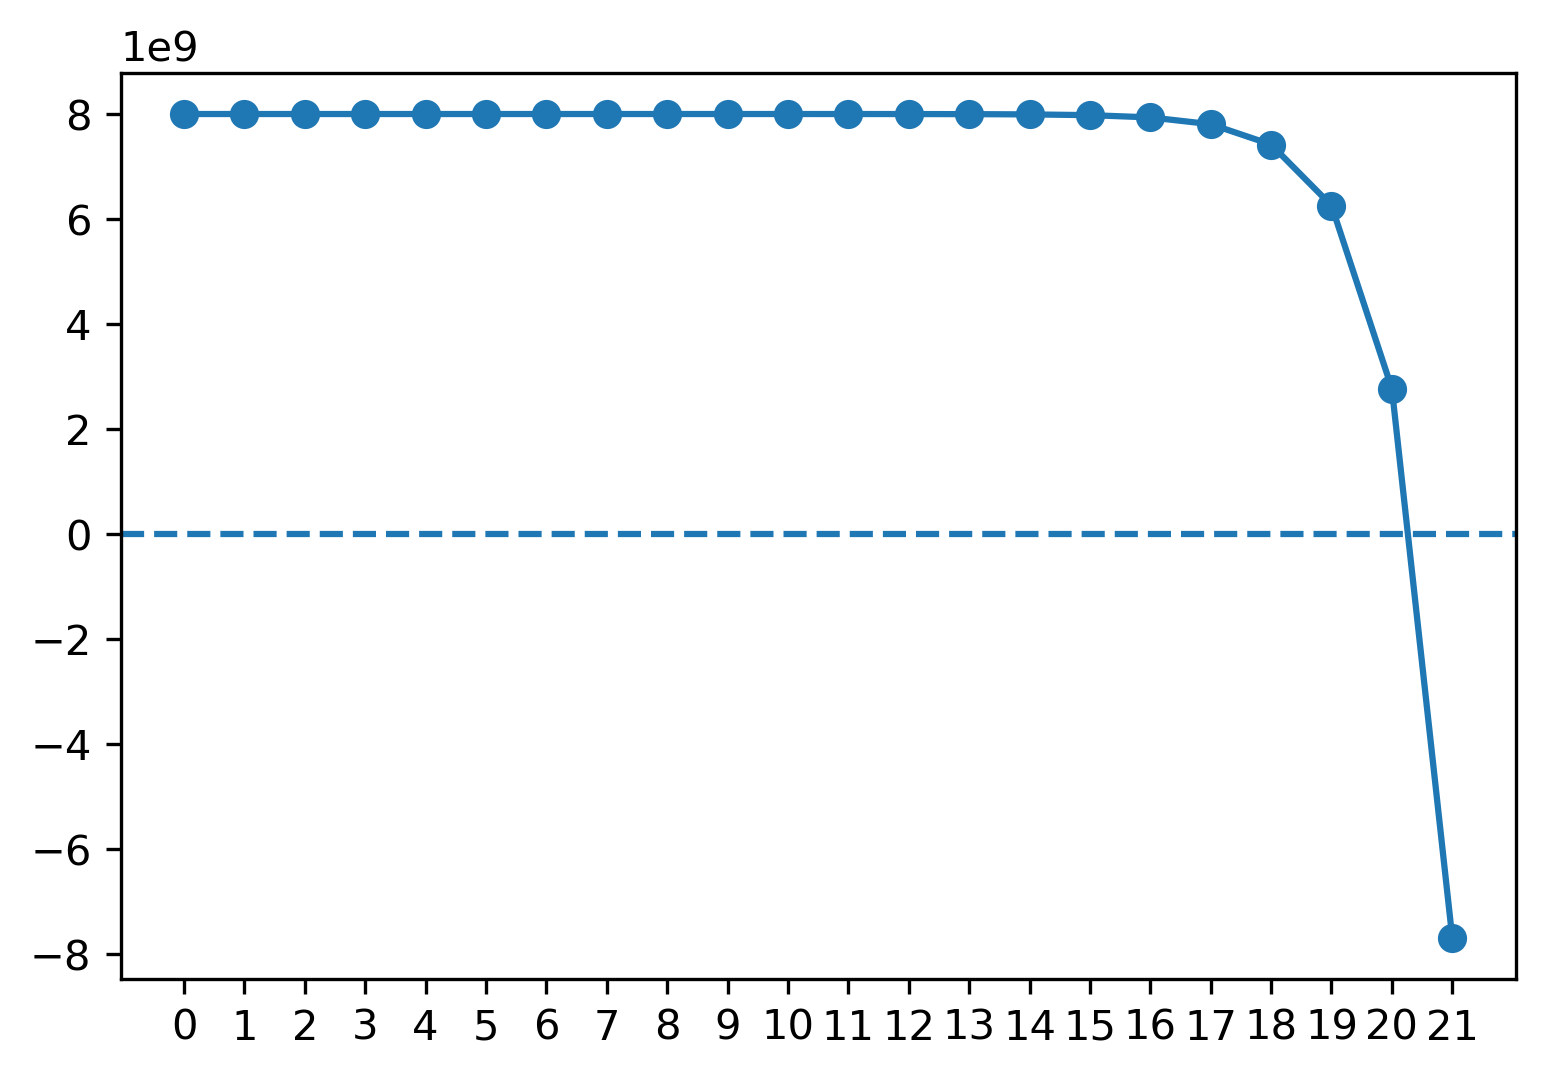

In [4]:
fig, ax = plt.subplots(dpi=300)
ax.plot(8*10**9 - np.cumsum([3**i for i in range(22)]), marker="o")
ax.axhline(0, ls="--")
ax.set_xticks(range(22))
plt.show()

From the plot we can tell that, under the above assumptions, we can only allow for a maximum of $g=20$ generations before we run out of people on earth.

Now that we have a reasonable estimate for `max_depth` ($g$) we are ready to model the spread of the virus. For this we defined the `spread` function. `spread` is a function that takes the epidemic parameters ($\theta$, $\phi$, $R_0$, $R_S$) as well as a root `Patient` (Patient zero) and `max_gen`.
Given `root` we create $n$ children. These are determined by a Poisson distribution with emission rate parameter $R_0$ for $\cdot A$ people and $R_S$ for $\cdot S$ people such that on average we obtain $\langle n_A\rangle = R_0$ and $\langle n_S\rangle = R_S$ new infections per person respectively. The created children participate in the contact-tracing network with probability $\phi$ and are asymptomic with probability $\theta$. After the children were created, the function checks whether one of the children is in the $CS$ category. If so it calls the `track` function for contact-tracing (discussed below). If not the process is recursively repeated. If the graph reaches a depth of `max_gen`-generations the functions return `True` indicating the the graph has percolated, i.e. that the outbreak could not be contained. If the graph ends early due to quaratine measures it return `False` indicating the outbreak has been contained. 

The second part is the `track` function. It takes a `root` node as argument. The function places `root` into quarantine ($Q$) and then checks all neighbouring nodes (children *and* parent) for the tracking attribute $C$. All neighbours that are participating in the contact tracing network $C\cdot$ are then put into quarantine. The process is again recursively repeated until all $C\cdot$ nodes have been place in quarantine. Note that nodes of type $N\cdot$ are unaffected.

In [5]:
def spread(root, theta, phi, R_0, R_S, curr_gen, max_gen):
    if curr_gen == max_gen:
        return True
    if root.state.quarantined:
        return False
    percolated = False
    for i in range(np.random.poisson(R_0) if root.state.asymptomatic else np.random.poisson(R_S)):
        state = PatientState(
            connected = True if np.random.rand() < phi else False, 
            asymptomatic = True if np.random.rand() < theta else False
        )
        root.add_child(Patient(root, state))
    if root.state.connected and not root.state.asymptomatic:
        track(root)
    for j,c in enumerate(root.children):
        percolated = percolated or spread(c, theta, phi, R_0, R_S, curr_gen+1, max_gen)
    return percolated

def track(root):
    neighbours = root.children if root.parent == None else root.children + [root.parent]
    neighbours = [el for el in neighbours if (el.state.connected and not el.state.quarantined)] # filter connected nodes
    for node in neighbours:
        node.state.quarantined = True
        track(node)

With this our model is already complete and we can explore different scenariors.

### No contact tracing

First we inspect the reference case in which no contact-tracing is employed, i.e. $\phi=0$. Below we plot the percolation probability $p_s(\theta)$ as a function of $\theta$. In this scenario we assume that $R_S=0$ for the moment, i.e. symptomatic individuals do *not* infect others. This means that only asymptomatic individuals grow the infection graph.

We see that the percolation probability stays at 0 up to a critical value $\theta_{crit}=\frac{1}{R_0}$ from where the probability rises until it reaches unity at $\theta = 1$.

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


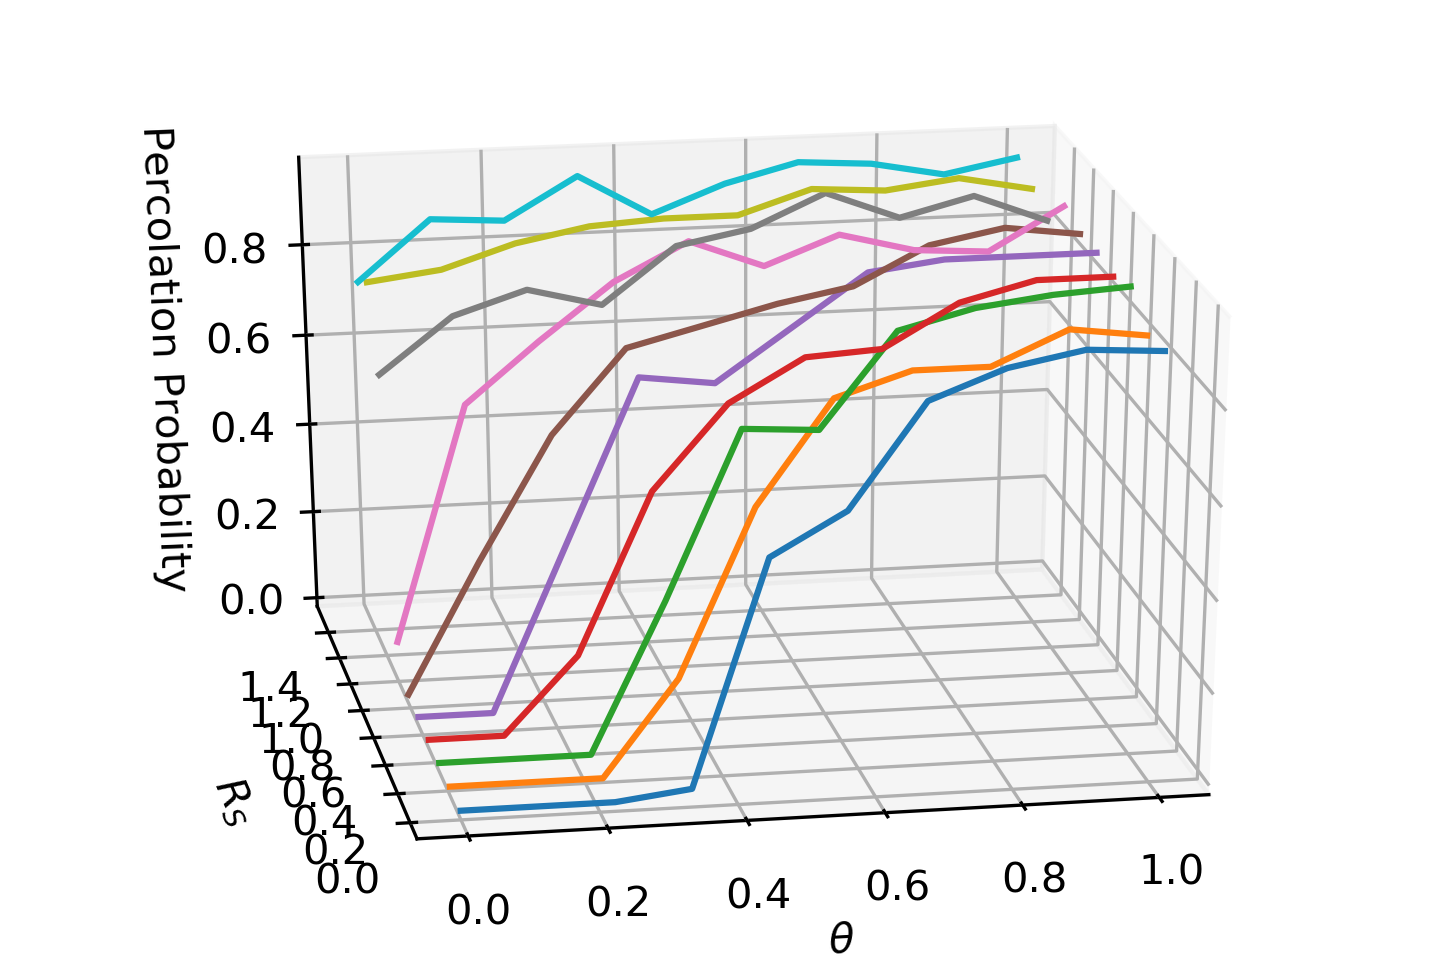

In [8]:
thetas = np.linspace(0,1,10)
Rs = np.linspace(0,1.5,10)
ps = np.zeros((len(Rs), len(thetas)))
for n, theta in enumerate(tqdm(thetas)):
    for m, R_s in enumerate(Rs):
        res = [spread(Patient(None, PatientState(False, True)), theta, 0.0, 3,R_s, 0, 100) for _ in range(100)]
        ps[m, n] = np.mean(res)
        
        
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
for m in range(len(Rs)):
    ax.plot(thetas, Rs[m]*np.ones(10), ps[m,:])
    
ax.view_init(elev=25, azim=-100)
ax.set_xlabel(r"$\theta$")
ax.set_zlabel(r"Percolation Probability")
ax.set_ylabel(r"$R_S$")
plt.show()

### With contact-tracing

In the second step we now consider the impact on containing the virus of a contact-tracing scheme. In our model the parameter $\phi$ controls the fraction of people that are taking part in the programme. We are now going to run the model for different variations of $(\phi, \theta)$ pairs and see how these impact the percolation probability $p_s$. The results are plotted below for varying $R_S$

100%|██████████| 20/20 [03:45<00:00, 11.26s/it]


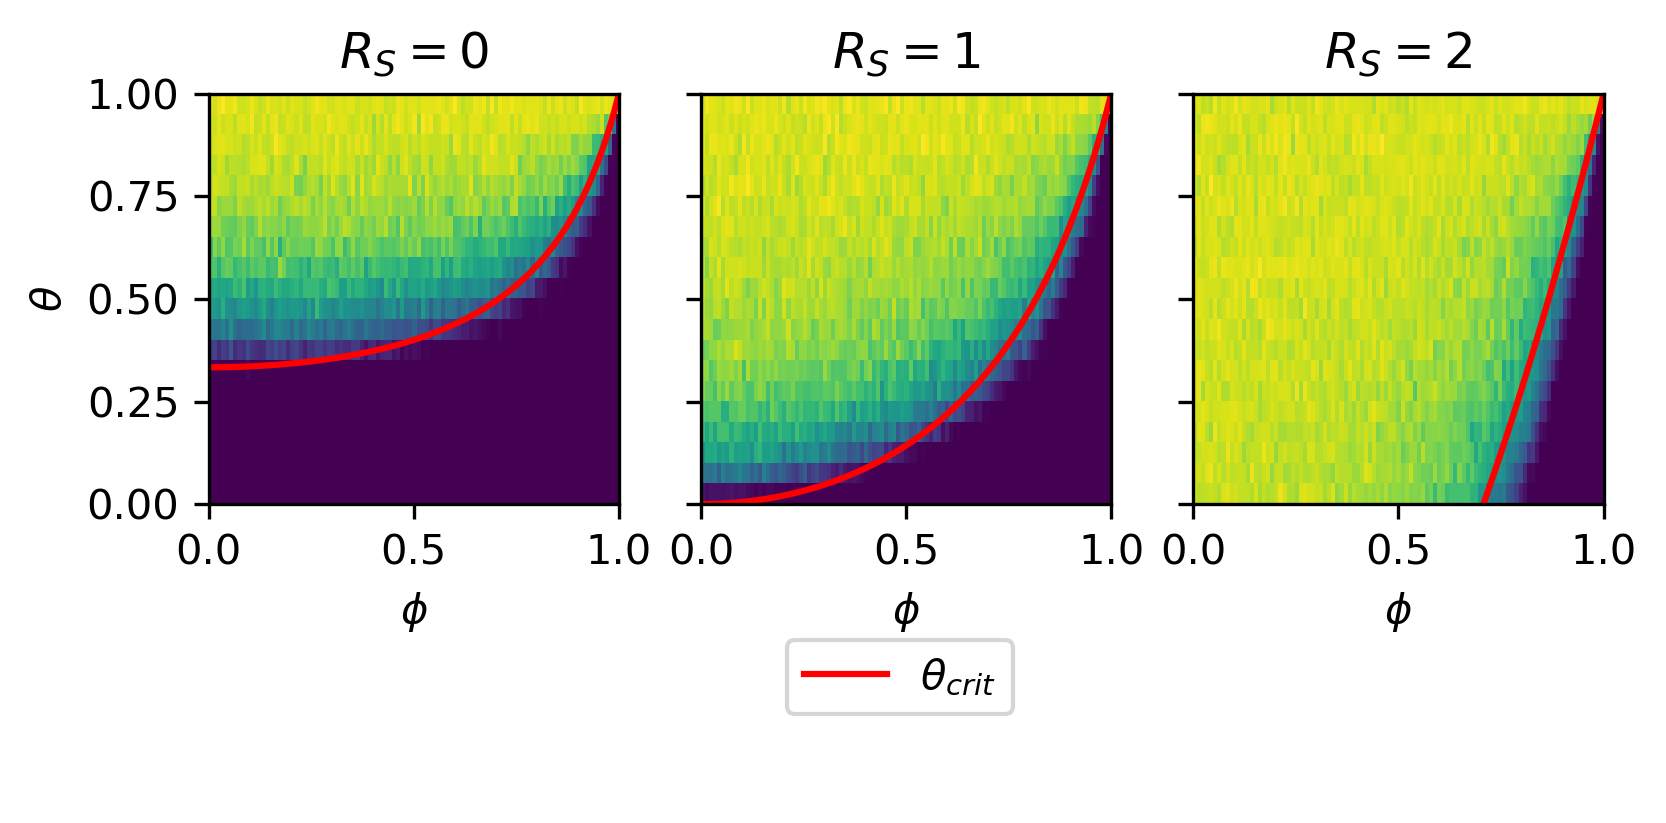

In [9]:
R_0 = 3

thetas = np.linspace(0,1,20)
phis = np.linspace(0,1,20)

fig, ax = plt.subplots(1,3,dpi=300, sharex=True, sharey=True)
phis = [i * 0.01 for i in range(101)]

for n, R_S in enumerate([0,1,2]):
    ps = np.zeros((len(phis), len(thetas)))
    for j, theta in enumerate(tqdm(thetas)):
        for i, phi in enumerate(phis):
            ps[i,j] = np.mean([spread(Patient(None, PatientState(False, True)), theta, phi, R_0, R_S, 0, 100) for _ in range(100)])
    img = ax[n].imshow(np.rot90(ps, k=1), extent = [0., 1., 0., 1.], origin="upper")
    theta_crits = [(1. - R_S*(1-phi**2))/ (phi ** 2 + (R_0-R_S) * (1 - phi ** 2)) for phi in phis]
    ax[n].plot(phis, theta_crits, label=r"$\theta_{crit}$", c="red")
    #ax[n].legend()
    ax[n].set_xlabel(r"$\phi$")
    ax[n].set_ylim(0,1)
    ax[n].set_title(r"$R_S={{{0}}}$".format(R_S))
    
ax[0].set_ylabel(r"$\theta$")
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.17))
plt.show()

In the above plot the red line represents the theoretical critical line separating the regimes where the virus can be contained ($p_s=0$) and regimes where the virus cannot be contained ($p_s = 1$). 

## Discussion

The above investigations reveal that contact-tracing apps are a very effective approach to containing the virus, even if a large fraction of the infected population does not show symptoms. In light of this it is indeed possible to achieve digital herd immunity, and the employment of large-scale contact-tracing schemes is warranted. However, there is no "gradual" improvement of the sitation with more people using the apps (i.e. large $\phi$ values).  There is a sudden "phase transition" from an uncontrolled spraid to containment along the critical $\theta$ line $\theta_{crit}$. This means that as long as a critical fraction $\phi_{crit}$ of people do not participate in the tracking scheme there is virtually no change in the percolation probability. It is only when the fraction of people participating exceeds $\phi_{crit}$ that the virus can be contained. Further the above results rely on the assumption that perfect tracking is possible, however in the real world we see that with spiking infection number many countries fail at that and infection chains are only partially traced. Finally people may not respect quarantine measures and thus further weaken the effect of the contact-tracing scheme. Still, in the early stages of the pandemic many countries succeeded with such a contact-tracing strategy, notably Japan, South Korea, Vietnam and Taiwan (see e.g. [D. Lewis, Why many countries failed at covid contact- tracing-but some got it right](https://media.nature.com/original/magazine-assets/d41586-020-03518-4/d41586-020-03518-4.pdf))

In summary we should work on advancing digitalisation and get more (especially older) people in touch with modern technology which, as we have seen, can have a noticable impact on the pandemic and can help is fight the still ongoing pandemic.